In [1]:
# Library imports
import tensorflow as tf
import numpy as np
keras = tf.keras
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# Add src directory to path for local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils import gpu_grow_memory

In [3]:
gpu_grow_memory()

In [4]:
print(f'TensorFlow version {tf.__version__}')
print(f'Eager execution: {tf.executing_eagerly()}')

TensorFlow version 2.0.0-beta0
Eager execution: True


In [7]:
data_url_trn = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
dataset_fp_trn = tf.keras.utils.get_file(fname=os.path.basename(data_url_trn), origin=data_url_trn)
print(f'Local copy of dataset: {dataset_fp_trn}')

Local copy of dataset: C:\Users\Michael\.keras\datasets\iris_training.csv


In [8]:
!head -n5 {dataset_fp_trn}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [9]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = col_names[0:-1]
label_name = col_names[-1]

print(f'Features: {feature_names}')
print(f'Label: {label_name}')

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [10]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [14]:
batch_size = 32
dataset_trn = tf.data.experimental.make_csv_dataset(
    dataset_fp_trn,
    batch_size,
    column_names=col_names,
    label_name = label_name,
    num_epochs=1)

In [16]:
features, labels = next(iter(dataset_trn))
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=122, shape=(32,), dtype=float32, numpy=
              array([7.7, 4.4, 6.4, 7.6, 6.4, 6.9, 4.6, 6.9, 5.6, 5.8, 5.4, 5.1, 6.2,
                     5. , 7.2, 6.4, 4.9, 4.8, 5. , 5.7, 6.8, 6.7, 6.3, 5.8, 5.7, 5.3,
                     4.4, 5.8, 5.4, 6.1, 6.3, 5. ], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=123, shape=(32,), dtype=float32, numpy=
              array([3. , 3. , 2.7, 3. , 3.2, 3.2, 3.6, 3.1, 2.9, 2.8, 3.4, 3.5, 2.8,
                     3.4, 3.2, 2.8, 2.4, 3. , 2.3, 4.4, 2.8, 3.1, 3.3, 2.7, 2.8, 3.7,
                     3.2, 4. , 3. , 2.6, 3.3, 3.5], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=120, shape=(32,), dtype=float32, numpy=
              array([6.1, 1.3, 5.3, 6.6, 4.5, 5.7, 1. , 4.9, 3.6, 5.1, 1.5, 1.4, 4.8,
                     1.5, 6. , 5.6, 3.3, 1.4, 3.3, 1.5, 4.8, 5.6, 4.7, 5.1, 4.5, 1.5,
                     1.3, 1.2, 4.5, 5.6, 6. , 1.

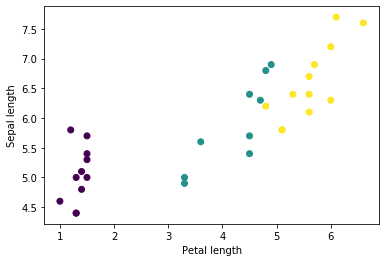

In [18]:
plt.scatter(features['petal_length'], features['sepal_length'], c=labels)
plt.xlabel('Petal length')
plt.ylabel('Sepal length')
plt.show()

In [19]:
def make_feature_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [20]:
dataset_trn = dataset_trn.map(make_feature_vector)

In [23]:
features, labels = next(iter(dataset_trn))
features[0:5]

<tf.Tensor: id=214, shape=(5, 4), dtype=float32, numpy=
array([[7.7, 3. , 6.1, 2.3],
       [4.4, 3. , 1.3, 0.2],
       [6.4, 2.7, 5.3, 1.9],
       [7.6, 3. , 6.6, 2.1],
       [6.4, 3.2, 4.5, 1.5]], dtype=float32)>

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

In [27]:
logits = model(features)
probs = tf.nn.softmax(logits)
preds = tf.argmax(logits, axis=1)

# The model probabilities (these are garbage now on an untrained model)
probs[0:5]

<tf.Tensor: id=362, shape=(5, 3), dtype=float32, numpy=
array([[0.32004026, 0.17566693, 0.50429285],
       [0.37079507, 0.22798678, 0.40121818],
       [0.323605  , 0.18803623, 0.48835877],
       [0.31460994, 0.15990928, 0.52548075],
       [0.32294518, 0.18558915, 0.4914656 ]], dtype=float32)>

In [28]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [30]:
def loss(model, x, y):
    y_pred = model(x)
    return loss_func(y_true=y, y_pred=y_pred)

In [31]:
loss_cur = loss(model, features, labels)
print(f'Current loss = {loss_cur:0.2f}')

Current loss = 1.05


In [32]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [41]:
loss_value, grads = grad(model, features, labels)
print(f'Step {optimizer.iterations.numpy()}, Loss = {loss_value.numpy():5.3f}')

optimizer.apply_gradients(zip(grads, model.trainable_variables))
loss_value, grads = grad(model, features, labels)
print(f'Step {optimizer.iterations.numpy()}, Loss = {loss_value.numpy():5.3f}')

Step 1, Loss = 1.003
Step 2, Loss = 0.987


In [46]:
hist_loss = []
hist_acc = []
for epoch in range(201):
    epoch_loss = tf.keras.metrics.Mean()
    epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    for x, y, in dataset_trn:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss(loss_value)
        epoch_acc(y, model(x))
    hist_loss.append(epoch_loss.result())
    hist_acc.append(epoch_acc.result())
    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}, loss {hist_loss[-1]:5.3f}, accuracy {hist_acc[-1]:0.4f}')

Epoch 000, loss 0.627, accuracy 0.7000
Epoch 050, loss 0.061, accuracy 0.9833
Epoch 100, loss 0.052, accuracy 0.9833
Epoch 150, loss 0.048, accuracy 0.9917
Epoch 200, loss 0.045, accuracy 0.9917


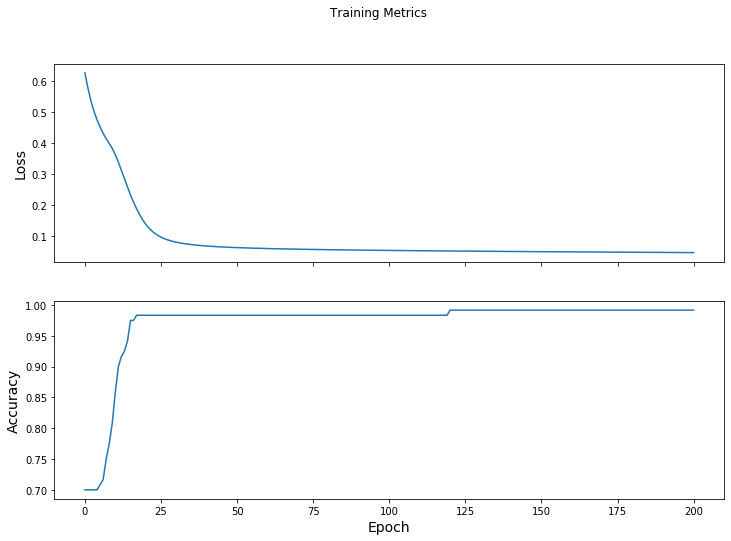

In [47]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(hist_loss)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(hist_acc)
plt.show()

In [48]:
data_url_tst = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
dataset_fp_tst = tf.keras.utils.get_file(fname=os.path.basename(data_url_tst), origin=data_url_tst)

In [56]:
dataset_tst = tf.data.experimental.make_csv_dataset(
    dataset_fp_tst,
    batch_size,
    column_names=col_names,
    label_name = label_name,
    num_epochs=1,
    shuffle=False)

dataset_tst = dataset_tst.map(make_feature_vector)

In [59]:
test_acc = tf.keras.metrics.Accuracy()

for (x, y) in dataset_tst:
    logits = model(x)
    pred = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_acc(pred, y)

print(f'Test set accuracy: {test_acc.result():.4f}')

Test set accuracy: 0.9667
